In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Getting files

###From CipiOrhei/TMBuD

In [ ]:
# import pathlib

# if not pathlib.Path('TMBuD').exists():
#     !git clone https://github.com/CipiOrhei/TMBuD.git

In [ ]:
# !mv TMBuD/files.txt /content
# !mv TMBuD/DATASET\ SPLIT.csv /content
# !mv TMBuD/gt_label /content
# !mv TMBuD/images /content

In [ ]:
# !sed -i 's/import thinning/#import thinning/' TMBuD/parse_database.py

In [ ]:
# !python TMBuD/parse_database.py --variant SEMSEG_EVAL_FULL

###From CMP Facade Database

In [ ]:
!wget -P /content/ https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
!wget -P /content/ https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip

In [ ]:
!mkdir /content/CMP_facade
!mkdir /content/CMP_facade_x
!unzip /content/CMP_facade_DB_base.zip -d /content/CMP_facade/
!unzip /content/CMP_facade_DB_extended.zip -d /content/CMP_facade_x/

##Imports

In [4]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

##Creating dataset

In [6]:
#@title Getting files pathes
base_data_path = '/content/CMP_facade/base'
extended_data_path = '/content/CMP_facade_x/extended'

base_image_paths = sorted([os.path.join(base_data_path, img) \
                           for img in os.listdir(base_data_path) \
                           if img.split('.')[-1] == 'jpg'])
base_mask_paths = sorted([os.path.join(base_data_path, mask) \
                          for mask in os.listdir(base_data_path) \
                          if mask.split('.')[-1] == 'png'])
base_annot_paths = sorted([os.path.join(base_data_path, annot) \
                          for annot in os.listdir(base_data_path) \
                          if annot.split('.')[-1] == 'xml'])

extended_image_paths = sorted([os.path.join(extended_data_path, img) \
                               for img in os.listdir(extended_data_path) \
                               if img.split('.')[-1] == 'jpg'])
extended_mask_paths = sorted([os.path.join(extended_data_path, mask) \
                              for mask in os.listdir(extended_data_path) \
                              if mask.split('.')[-1] == 'png'])
extended_annot_paths = sorted([os.path.join(extended_data_path, annot) \
                              for annot in os.listdir(extended_data_path) \
                              if annot.split('.')[-1] == 'xml'])

print(f'Base images - {len(base_image_paths)}, base masks - {len(base_mask_paths)}')
print(f'Extended images - {len(extended_image_paths)}, extended masks - {len(extended_mask_paths)}')

all_image_paths = base_image_paths + extended_image_paths
all_mask_paths = base_mask_paths + extended_mask_paths
all_annot_paths = base_annot_paths + extended_annot_paths

print(f'All images - {len(all_image_paths)}, all masks - {len(all_mask_paths)}')

Base images - 378, base masks - 378
Extended images - 228, extended masks - 228
All images - 606, all masks - 606


In [7]:
#@title Support functions
def imageLoadPreprocess(image_path=None, mask_path=None):
    if image_path is not None:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image.set_shape([None, None, 3])
        resized_image = tf.image.resize(image, (256, 256))
        return resized_image
    if mask_path is not None:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_image(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask.set_shape([None, None, 1])
        resized_mask = tf.image.resize(mask, (256, 256))
        return resized_mask

def showImageMaskPair(image, mask):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image, interpolation='none')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image, interpolation='none')
    plt.imshow(mask, 'jet', interpolation='none', alpha=0.7)
    plt.axis('off')
    plt.show()

###Creating dataset

In [8]:
num_imgs = 580
buildings_dataset = tf.data.Dataset.from_tensor_slices(all_image_paths[:num_imgs])
buildings_dataset = buildings_dataset.map(lambda x: imageLoadPreprocess(image_path=x))

masks_dataset = tf.data.Dataset.from_tensor_slices(all_mask_paths[:num_imgs])
masks_dataset = masks_dataset.map(lambda x: imageLoadPreprocess(mask_path=x))

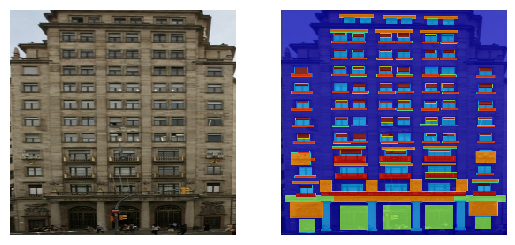

In [9]:
example_b = buildings_dataset.take(1).get_single_element()
example_m = masks_dataset.take(1).get_single_element()
showImageMaskPair(example_b, example_m)

In [10]:
# @title Dict way to get masks coordinates
# Slowly
# !pip install xmltodict
# import xmltodict

# def getWindowsPointsFromDict(annot_path):
#     """Return: related coordinates [rx_min, rx_max, ry_min, ry_max]
#     of windows bounding boxes"""
#     with open(annot_path) as f:
#         xml = f.read()
#     xml_dict = xmltodict.parse("<root>" + xml + "</root>")['root']['object']

#     windows_points = []
#     for obj in xml_dict:
#         if obj.get('labelname') == 'window':
#             x_points = obj.get('points').get('x')
#             y_points = obj.get('points').get('y')
#             rx_min, rx_max = float(x_points[0]), float(x_points[1])
#             ry_min, ry_max = float(y_points[0]), float(y_points[1])
#             windows_points.append([rx_min, rx_max, ry_min, ry_max])
#     return windows_points

# %timeit getWindowsPointsFromDict(all_annot_paths[0])

In [11]:
# @title XML ElementTree way to get masks coordinates
# Faster
def getWindowsPoints(annot_path):
    """Return: related coordinates [rx_min, rx_max, ry_min, ry_max]
    of windows bounding boxes"""
    with open(annot_path) as f:
        xml = f.read()
    tree = ET.fromstring("<root>" + xml + "</root>")

    windows_points = []
    for obj in tree:
        labelname = obj.find('labelname').text[1:-1]
        points = obj.find('points')
        if labelname == 'window':
            x_points = points.findall('x')
            y_points = points.findall('y')
            rx_min, rx_max = float(x_points[0].text), float(x_points[1].text)
            ry_min, ry_max = float(y_points[0].text), float(y_points[1].text)
            windows_points.append([rx_min, rx_max, ry_min, ry_max])
    return windows_points

# %timeit getWindowsPoints(all_annot_paths[0])

In [12]:
def getWindowsPointsDataset(annots_paths):
    return [getWindowsPoints(annot_path) for annot_path in annots_paths]

In [13]:
all_buildings_windows_coords = getWindowsPointsDataset(base_annot_paths)

In [14]:
def getWindowsSegments(windows_coords, image_shape):
    bg = np.zeros(image_shape, dtype=np.float32)
    for window in windows_coords:
        x_min, x_max = int(window[0] * bg.shape[0]), int(window[1] * bg.shape[0])
        y_min, y_max = int(window[2] * bg.shape[1]), int(window[3] * bg.shape[1])
        bg[x_min:x_max, y_min:y_max] = 1.0
    bg = tf.constant(bg)
    return bg

def getAllBuildingsWindowsSegments(all_windows_coords, images_shapes):
    windows_segs_dataset = []
    for i in range(len(all_windows_coords)):
        windows_segs = getWindowsSegments(all_windows_coords[i], images_shapes[i])
        windows_segs_dataset.append(windows_segs)
    return windows_segs_dataset

In [15]:
images_shapes = [image.shape for image in buildings_dataset.as_numpy_iterator()]
building_windows = getAllBuildingsWindowsSegments(all_buildings_windows_coords, images_shapes)

In [16]:
# examples = buildings_dataset.take(5).enumerate()
# for idx, image in examples:
#     showImageMaskPair(image, building_windows[idx])

In [17]:
windows_dataset = tf.data.Dataset.from_tensor_slices(building_windows)
windows_dataset = windows_dataset.map(tf.image.rgb_to_grayscale)

In [18]:
dataset = tf.data.Dataset.zip(buildings_dataset, windows_dataset)
dataset = dataset.batch(16)

In [19]:
dataset_length = dataset.cardinality().numpy()
train_size = int(dataset_length * 0.8)

train_data = dataset.take(train_size)
test_data = dataset.skip(train_size)

In [20]:
# examples = train_data.take(3).as_numpy_iterator()
# for image, mask in examples:
#     showImageMaskPair(image[0], mask[0])

##Creating model

In [22]:
def buildUNetModel():
    x = tf.keras.layers.Input((256, 256, 3))

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out = tf.keras.layers.BatchNormalization()(out)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out1)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out2)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out3)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out4)
    out = tf.keras.layers.MaxPool2D((2, 2))(out)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dropout(0.25)(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    out = tf.keras.layers.BatchNormalization()(out)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

##Training model

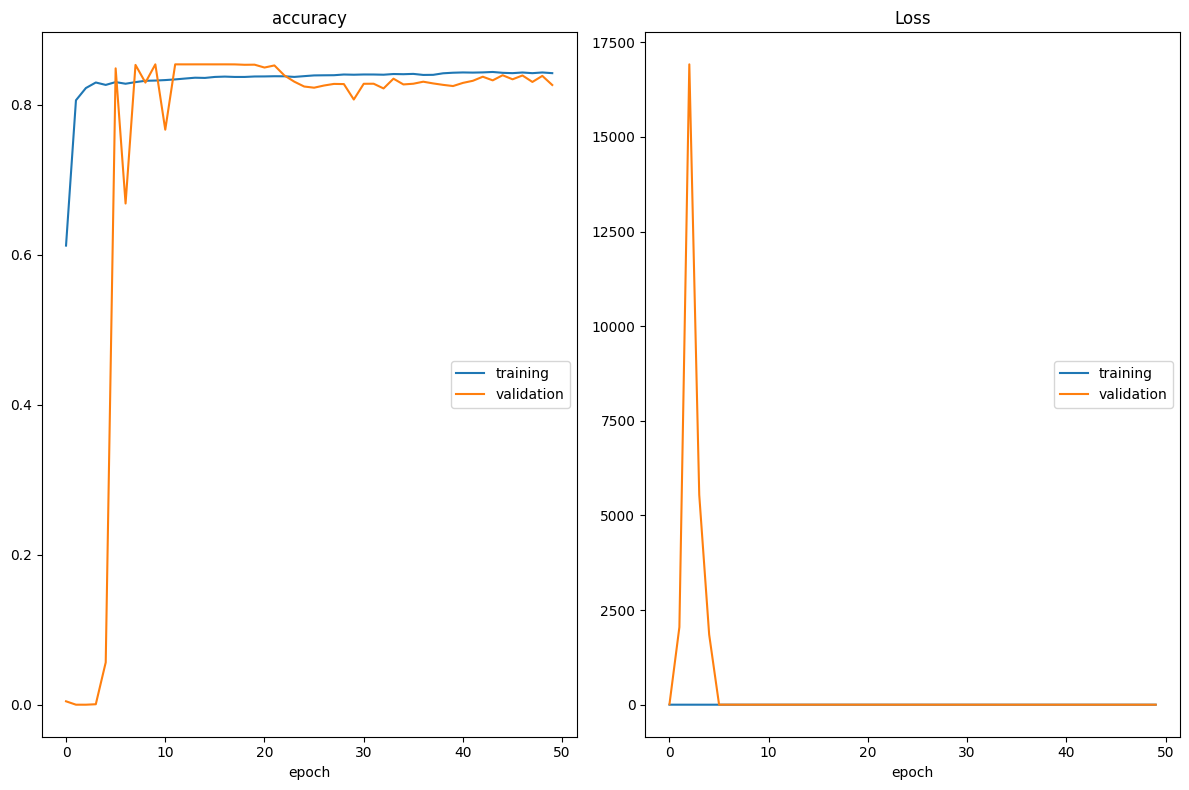

accuracy
	training         	 (min:    0.612, max:    0.844, cur:    0.842)
	validation       	 (min:    0.000, max:    0.854, cur:    0.826)
Loss
	training         	 (min:    0.044, max:    0.634, cur:    0.046)
	validation       	 (min:    0.269, max: 16916.924, cur:    0.344)
19/19 [==============================] - 30s 2s/step - loss: 0.0464 - accuracy: 0.8421 - val_loss: 0.3437 - val_accuracy: 0.8263


In [23]:
model_path = '/content/drive/My Drive/Building_Analytics_CV/U_Net_model/model'
EPOCHS = 50

model = buildUNetModel()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_data,
                 validation_data=test_data,
                 epochs=EPOCHS,
                 callbacks=[PlotLossesCallback()])

model.save(model_path)

##Load model

In [22]:
model_path = '/content/drive/My Drive/Building_Analytics_CV/U_Net_model/model'
model = tf.keras.saving.load_model(model_path)

##Getting segmentation

In [31]:
#@title Support functions
def getTestImages(paths, n=3):
    random_images = random.choices(paths, k=n)
    test_images = []
    for img in random_images:
        with Image.open(img) as image:
            image.load()
        image_arr = np.array(image.resize((256, 256))) / 255
        test_images.append(image_arr)
    return test_images

def getSomePredictions(images):
    for sample in images:
        pred = model.predict(sample[None, ...])
        seg_map = (pred[0, ..., 0] > 0.5).astype(np.float32)
        showImageMaskPair(sample, seg_map)

1/1 [==============================] - 0s 22ms/step


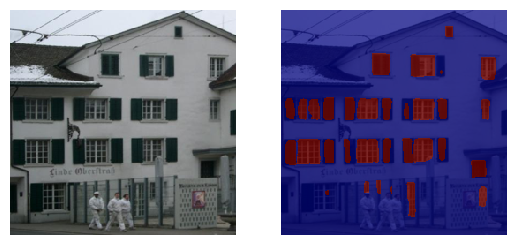

1/1 [==============================] - 0s 20ms/step


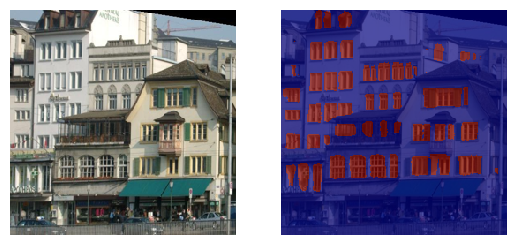

In [37]:
test_images = getTestImages(all_image_paths[num_imgs:], n=2)
getSomePredictions(test_images)